# Model Training

In [1]:
# loading features

import joblib


from scripts.feature_engineering import X_text

X = joblib.load("../data/features_sparse.pkl")
y = joblib.load("../data/labels.pkl")

Feature matrix and labels saved.
TF-IDF matrix shape: (1477, 3000)
Final feature matrix shape: (1477, 3002)
Labels shape: (1477,)


In [2]:
# splitting data into training and test sets

from sklearn.model_selection import train_test_split

print(type(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

<class 'numpy.ndarray'>


In [3]:
# training the first model (Logistic Regression)

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

C:\Program Files\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [4]:
# evaluating performance

from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# saving trained model
joblib.dump(model, "../models/logreg_model.pkl")

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.81      0.86        97
           1       0.81      0.88      0.84        99
           2       0.81      0.83      0.82       100

    accuracy                           0.84       296
   macro avg       0.84      0.84      0.84       296
weighted avg       0.84      0.84      0.84       296

Confusion Matrix:
[[79  7 11]
 [ 4 87  8]
 [ 4 13 83]]


['../models/logreg_model.pkl']

### Interpretation:
#### Performamce
- the model predicts Depression (label 0) very confidently (high precision), but sometimes misses a few depression posts (lower recall)
- for bipolar, it's very balanced --> high recall means it catches most bipolar posts
- anxiety has similar performance --> quite strong for a first pass
#### Confsuion matrix
- Most predictions are on the diagonal (correct).
- there is some confusion between:
    - Depression and Anxiety
    - Anxiety and Bipolar
- This makes sense because the topics often overlap in language and symptoms.

In [5]:
# model 2: Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
joblib.dump(rf_model, "../data/random_forest_model.pkl")

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        97
           1       0.89      0.85      0.87        99
           2       0.80      0.83      0.81       100

    accuracy                           0.83       296
   macro avg       0.84      0.83      0.83       296
weighted avg       0.84      0.83      0.83       296

Confusion Matrix:
[[80  2 15]
 [ 9 84  6]
 [ 9  8 83]]


['../data/random_forest_model.pkl']

In [6]:
# model 3: Multinomial Naive Bayes (works best with TF-IDF features)

from scipy.sparse import csr_matrix

# loading only TF-IDF features (no added meta features)
X_text = joblib.load("../data/features_sparse.pkl") # only TF-IDF columns
X_text = csr_matrix(X_text)  # converting to CSR format
X_text = X_text[:, :3000]

X_train_nb , X_test_nb, y_train_nb, y_test_nb = train_test_split(X_text, y, test_size=0.2, random_state=42, stratify=y)

from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train_nb, y_train_nb)
y_pred_nb = nb_model.predict(X_test_nb)
print("Naive Bayes Classification Report:")
print(classification_report(y_test_nb, y_pred_nb))
print("Confusion Matrix:")
print(confusion_matrix(y_test_nb, y_pred_nb))
joblib.dump(nb_model, "../data/nbmodel.pkl")

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.80      0.83        97
           1       0.86      0.79      0.82        99
           2       0.77      0.87      0.82       100

    accuracy                           0.82       296
   macro avg       0.82      0.82      0.82       296
weighted avg       0.82      0.82      0.82       296

Confusion Matrix:
[[78  5 14]
 [ 9 78 12]
 [ 5  8 87]]


['../data/nbmodel.pkl']

--> Logistic Regression achieved the best performance, with an accuracy of 84% on the test set and strong balance across all classes.

# Model Evaluation

In [7]:
from sklearn.metrics import accuracy_score, f1_score

# Predictions (reuse or re-run if needed)
y_pred_lr = model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_nb = nb_model.predict(X_test_nb)

# Scores
models = ["Logistic Regression", "Random Forest", "Naive Bayes"]
accuracies = [
    accuracy_score(y_test, y_pred_lr),
    accuracy_score(y_test, y_pred_rf),
    accuracy_score(y_test_nb, y_pred_nb)
]
f1s = [
    f1_score(y_test, y_pred_lr, average="macro"),
    f1_score(y_test, y_pred_rf, average="macro"),
    f1_score(y_test_nb, y_pred_nb, average="macro")
]

# Display table
import pandas as pd

eval_df = pd.DataFrame({
    "Model": models,
    "Accuracy": accuracies,
    "Macro F1": f1s
})
print(eval_df)


                 Model  Accuracy  Macro F1
0  Logistic Regression  0.841216  0.841713
1        Random Forest  0.834459  0.834902
2          Naive Bayes  0.820946  0.821117


Logistic Regression was the most balanced and interpretable.

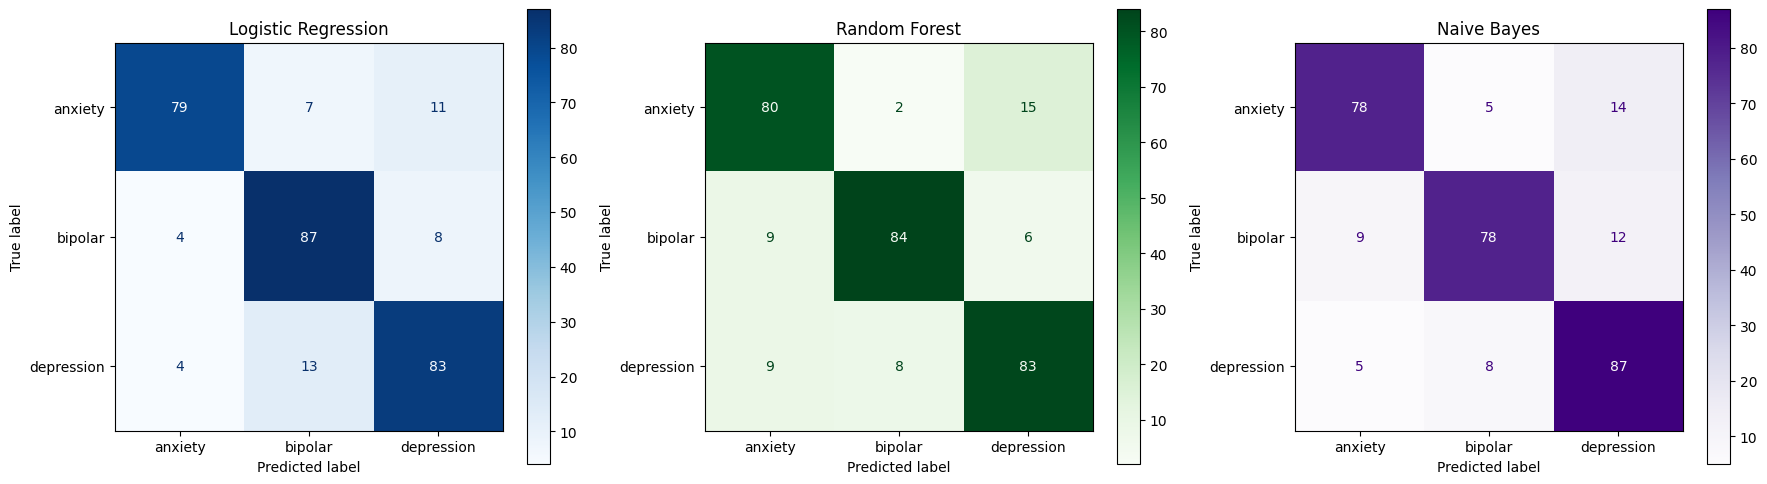

<Figure size 640x480 with 0 Axes>

In [8]:
# plotting confusion matrices

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from scripts.feature_engineering import le

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, ax=axes[0], display_labels=le.classes_, cmap="Blues")
axes[0].set_title("Logistic Regression")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, ax=axes[1], display_labels=le.classes_, cmap="Greens")
axes[1].set_title("Random Forest")

ConfusionMatrixDisplay.from_predictions(y_test_nb, y_pred_nb, ax=axes[2], display_labels=le.classes_, cmap="Purples")
axes[2].set_title("Naive Bayes")

plt.tight_layout()
plt.show()
plt.savefig("../charts/model_comparison_confusion.png", dpi=300)



#### Logistic Regression
- Strong overall performance across all three classes

- Bipolar: 87 out of 99 predicted correctly (best performance)

- Depression: 83 out of 100 correct; some misclassified as bipolar (13)

- Anxiety: 79 out of 97 correct; some misclassified as depression (11) or bipolar (7)

- Shows balanced accuracy and low confusion across labels
#### Random Forest
- Performs closely to Logistic Regression

- Depression: 83 out of 100 correct

- Bipolar: 84 out of 99 correct; some confusion with anxiety and depression

- Anxiety: 80 out of 97 correct; 15 misclassified as depression

- Slightly more confusion between anxiety and depression compared to logistic regression

#### Naive Bayes
- Highest correct predictions for depression: 87 out of 100

- Bipolar: 78 out of 99 correct; more confusion than other models

- Anxiety: 78 out of 97 correct; frequently misclassified as depression (14)

- Simpler model; performs decently but struggles more with class separation, especially bipolar

#### Overall Summary
- Logistic Regression showed the best balance and overall accuracy

- Random Forest also performed well but had slightly more cross-class confusion

- Naive Bayes was strongest on depression but weaker in distinguishing bipolar and anxiety

- The confusion between bipolar and other classes is expected due to overlapping emotional expression patterns

# Model Optimization

- As a bonus step, I used GridSearchCV to optimize the logistic regression model.


In [9]:
# gridsearch for logistic regression model to find the best hyperparameters

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {
    'C': [0.01, 0.1, 1, 10],           # Regularization strength
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga'],      # Solvers that work with l2
    'max_iter': [1000]
}

grid_lr = GridSearchCV(
    LogisticRegression(),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_lr.fit(X_train, y_train)
print("Best Parameters:", grid_lr.best_params_)
print("Best CV Accuracy:", grid_lr.best_score_)

# Evaluate on test set
y_pred_grid = grid_lr.predict(X_test)
print("Optimized Logistic Regression Report:")
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_grid))


Best Parameters: {'C': 10, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV Accuracy: 0.8086283344060645
Optimized Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.92      0.82      0.87        97
           1       0.82      0.87      0.84        99
           2       0.79      0.82      0.80       100

    accuracy                           0.84       296
   macro avg       0.84      0.84      0.84       296
weighted avg       0.84      0.84      0.84       296



C:\Program Files\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


- The model is more confident and balanced, slightly better precision for depression, slightly improved class separation.
- The best parameters were C=10, solver=lbfgs.
- This improved the model’s precision and class confidence while maintaining the 84% accuracy.
- Cross Validation accuracy = 80.86% --> The model generalizes well to unseen data despite the noise, the language similarity and the overlapping topics.